## Подготовка данных

Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import r2_score

#!pip install -U jaxlib==0.4.20+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Чтение входного файла

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/powerconsumption.csv')

df

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [ ]:
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


## Визуализация данных

График визуализации связей между числовыми столбцами

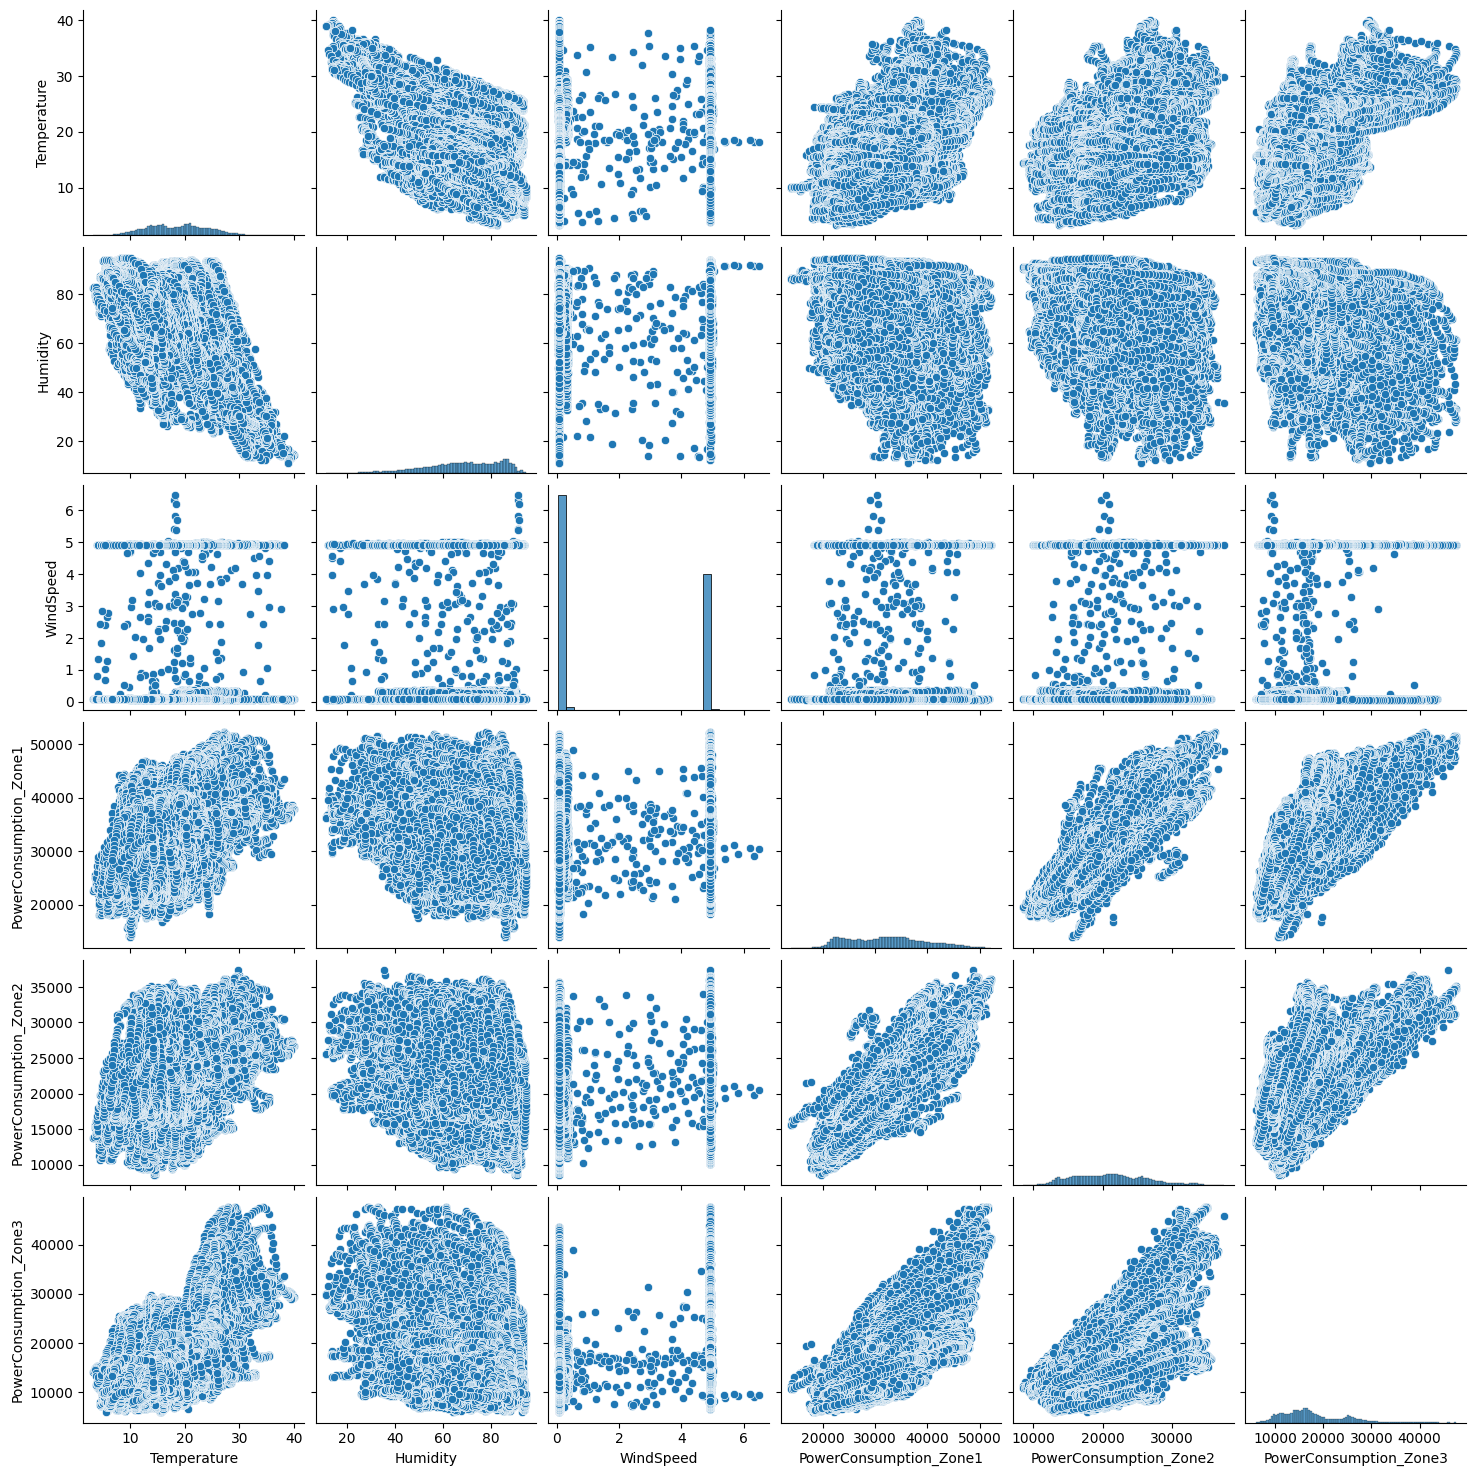

In [ ]:
sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])

plt.show()

График временного ряда для энергопотребления

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone1', data=df, label='Zone 1')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone2', data=df, label='Zone 2')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone3', data=df, label='Zone 3')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

## Предварительная обработка данных

Проверка данных на сохранение хронологического порядка и на равные временные отрезки

In [ ]:
df['Datetime']=pd.to_datetime(df.Datetime)
df.sort_values(by='Datetime', ascending=True, inplace=True)

chronological_order = df['Datetime'].is_monotonic_increasing

time_diffs = df['Datetime'].diff()
equidistant_timestamps = time_diffs.nunique() == 1

chronological_order, equidistant_timestamps

(True, True)

Всё хорошо: Интервал времени 10 минут и данные расположены в хронологическом порядке.

Проверка наличия нулевых ячеек

In [ ]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

## Разработка функций

Создание функций временных рядов на основании индексов временных рядов.

In [ ]:
def create_features(df):
    # Создадим столбцы под каждое измерение времени

    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.month
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Дополнительные характеристики
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)
    df['is_quarter_start'] = (df['dayofmonth'] == 1) & (df['month'] % 3 == 1).astype(int)
    df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max'))

    # Дополнительные характеристики
    df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)

    # Дополнительные характеристики
    df['minute_of_day'] = df['hour'] * 60 + df['minute']
    df['minute_of_week'] = (df['dayofweek'] * 24 * 60) + df['minute_of_day']

    return df.astype(float)

In [ ]:
df = df.set_index('Datetime')
df = create_features(df)

In [ ]:
df[[ 'year', 'month', 'day','minute', 'dayofyear', 'weekofyear', 'quarter', 'season']].head()

,year,month,day,minute,dayofyear,weekofyear,quarter,season
Datetime,,,,,,,,
2017-01-01 00:00:00,2017.0,1.0,1.0,0.0,1.0,52.0,1.0,1.0
2017-01-01 00:10:00,2017.0,1.0,1.0,10.0,1.0,52.0,1.0,1.0
2017-01-01 00:20:00,2017.0,1.0,1.0,20.0,1.0,52.0,1.0,1.0
2017-01-01 00:30:00,2017.0,1.0,1.0,30.0,1.0,52.0,1.0,1.0
2017-01-01 00:40:00,2017.0,1.0,1.0,40.0,1.0,52.0,1.0,1.0


In [ ]:
df[[ 'is_weekend', 'dayofweek', 'is_working_day']].head()

,is_weekend,dayofweek,is_working_day
Datetime,,,
2017-01-01 00:00:00,1.0,6.0,0.0
2017-01-01 00:10:00,1.0,6.0,0.0
2017-01-01 00:20:00,1.0,6.0,0.0
2017-01-01 00:30:00,1.0,6.0,0.0
2017-01-01 00:40:00,1.0,6.0,0.0


## Исследовательский анализ данных

Посмотрим на матрицу корреляций

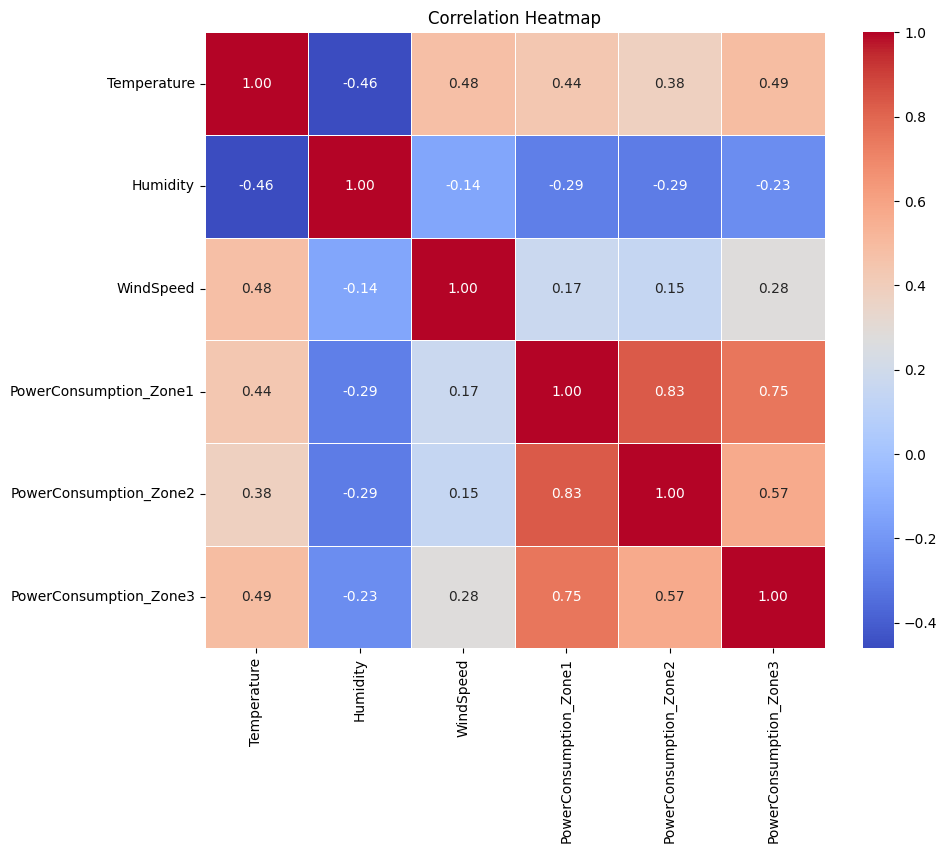

In [ ]:
correlation_matrix = df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Повторная (ежедневная) выборка данных

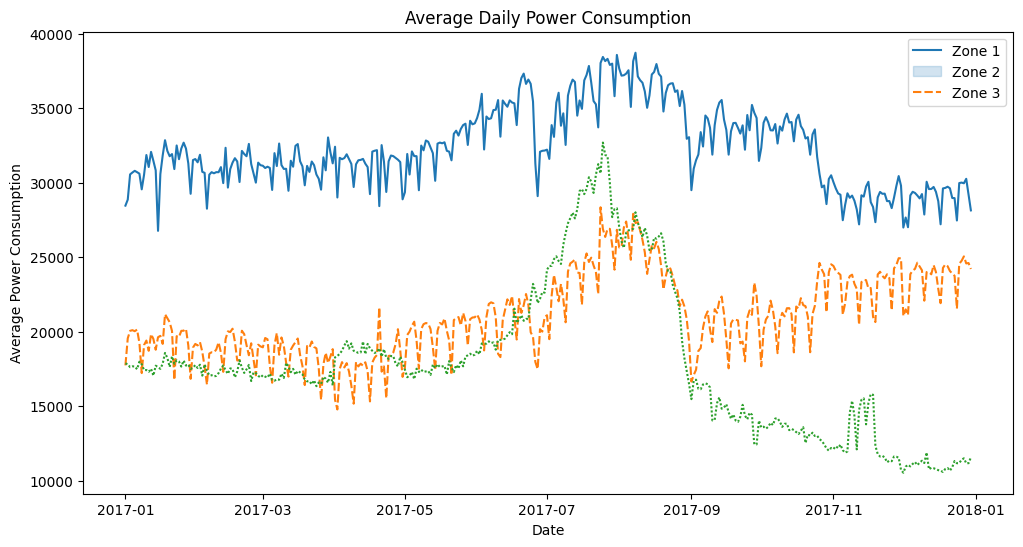

In [ ]:
daily_resampled = df.resample('D').mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_resampled[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend(labels=['Zone 1', 'Zone 2', 'Zone 3'])
plt.show()

## Моделирование

In [ ]:
from sklearn.preprocessing import StandardScaler

# Разделение входных объектов (X) и целевых объектов (y)
X = df.drop(['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], axis=1)
y = df[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']]

# Инициализировать StandardScaler для y
scaler_y = StandardScaler()

# Подгон и трансформация  y
y_scaled = scaler_y.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.25, shuffle=False)

## Multilayer Perceptron модель

In [ ]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(3))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

In [ ]:
mlp_history = model_mlp.fit(X_train.values, y_train,
                            validation_data=(X_test.values, y_test), epochs=epochs, verbose=2)

In [ ]:
train_predict = model_mlp.predict(X_train)
test_predict = model_mlp.predict(X_test)

# Подсчёт СКО и САО
mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)

# Вывод результатов
print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

410/410 [==============================] - 1s 1ms/step
Mean squared error on test set: 0.9556
Mean absolute error on test set: 0.7425


## CNN модель

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (39312, 26, 1)
Validation set shape (13104, 26, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(3))
model_cnn.compile(loss='mse', optimizer='adam')
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 12, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                38450     
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 38795 (151.54 KB)
Trainable params: 38795 (151.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
cnn_history = model_cnn.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
1229/1229 - 4s - loss: 9.2721 - val_loss: 0.5796 - 4s/epoch - 3ms/step
Epoch 2/40
1229/1229 - 4s - loss: 1.2605 - val_loss: 0.5332 - 4s/epoch - 4ms/step
Epoch 3/40
1229/1229 - 3s - loss: 1.0276 - val_loss: 0.7697 - 3s/epoch - 3ms/step
Epoch 4/40
1229/1229 - 3s - loss: 1.0318 - val_loss: 0.8268 - 3s/epoch - 3ms/step
Epoch 5/40
1229/1229 - 3s - loss: 0.8920 - val_loss: 0.7587 - 3s/epoch - 2ms/step
Epoch 6/40
1229/1229 - 4s - loss: 0.7672 - val_loss: 0.5661 - 4s/epoch - 4ms/step
Epoch 7/40
1229/1229 - 3s - loss: 0.6777 - val_loss: 0.7193 - 3s/epoch - 3ms/step
Epoch 8/40
1229/1229 - 3s - loss: 0.6782 - val_loss: 0.9613 - 3s/epoch - 3ms/step
Epoch 9/40
1229/1229 - 3s - loss: 0.5918 - val_loss: 0.9289 - 3s/epoch - 2ms/step
Epoch 10/40
1229/1229 - 4s - loss: 0.4725 - val_loss: 0.8688 - 4s/epoch - 3ms/step
Epoch 11/40
1229/1229 - 4s - loss: 0.6627 - val_loss: 0.6207 - 4s/epoch - 3ms/step
Epoch 12/40
1229/1229 - 3s - loss: 0.3687 - val_loss: 0.5960 - 3s/epoch - 2ms/step
Epoch 13/40
1

In [ ]:
train_predict = model_cnn.predict(X_train)
test_predict = model_cnn.predict(X_test)


# Подсчёт СКО и САО
mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)

# Вывод результатов
print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

410/410 [==============================] - 1s 1ms/step
Mean squared error on test set: 0.4880
Mean absolute error on test set: 0.5429


## LSTM модель

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(3))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10553 (41.22 KB)
Trainable params: 10553 (41.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/40
1229/1229 - 16s - loss: 3418.3882 - val_loss: 45.4611 - 16s/epoch - 13ms/step
Epoch 2/40
1229/1229 - 17s - loss: 13.2815 - val_loss: 25.4613 - 17s/epoch - 14ms/step
Epoch 3/40
1229/1229 - 14s - loss: 7.1971 - val_loss: 9.4939 - 14s/epoch - 11ms/step
Epoch 4/40
1229/1229 - 14s - loss: 2.8674 - val_loss: 5.3659 - 14s/epoch - 12ms/step
Epoch 5/40
1229/1229 - 14s - loss: 1.4943 - val_loss: 3.8035 - 14s/epoch - 12ms/step
Epoch 6/40
1229/1229 - 14s - loss: 3.1134 - val_loss: 0.8207 - 14s/epoch - 12ms/step
Epoch 7/40
1229/1229 - 14s - loss: 0.5106 - val_loss: 0.6311 - 14s/epoch - 12ms/step
Epoch 8/40
1229/1229 - 14s - loss: 0.3877 - val_loss: 0.4903 - 14s/epoch - 12ms/step
Epoch 9/40
1229/1229 - 14s - loss: 0.3472 - val_loss: 0.6654 - 14s/epoch - 12ms/step
Epoch 10/40
1229/1229 - 14s - loss: 0.2608 - val_loss: 0.8118 - 14s/epoch - 12ms/step
Epoch 11/40
1229/1229 - 14s - loss: 0.2667 - val_loss: 0.6954 - 14s/epoch - 12ms/step
Epoch 12/40
1229/1229 - 14s - loss: 0.2543 - val_loss: 0.

In [ ]:
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)


# Подсчёт СКО и САО
mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)

# Вывод результатов
print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

410/410 [==============================] - 2s 4ms/step
Mean squared error on test set: 1.1362
Mean absolute error on test set: 0.8050


## Xgboost модель

In [ ]:
# Define the hyperparameter grid for XGBoost
param_grid = {
    'objective':['reg:squarederror'],
    'max_depth': [2, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7],
    'n_estimators': [1000,1500,2000],
    'min_child_weight': [1, 2],
    'booster':['gbtree']
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor(tree_method='hist', device = 'cuda')


# Create the GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=7, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluate the model on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:13:07] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:13:16] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:13:21] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:13:31] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:13:36] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.


In [ ]:
model =  grid_search.best_estimator_

In [ ]:
xgboost_history = model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=200)

Попытка предсказания с помощью модели

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)

In [ ]:
Важность характеристик

In [ ]:
_ = plot_importance(model, height=0.9)

## Сравнение моделей

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

plt.show()